# WingsNet

In [ ]:
#General OS and numerical
# %matplotlib qt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import argparse
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange as trange
import itertools
from PIL import Image
from collections import OrderedDict
import re

#Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

#Data management
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

#Image processing
import cv2 as cv
from torchvision import transforms

import random

matplotlib.use("Agg")

## Args/Params

In [ ]:
#GPUs
print("CUDA availability = {}, number devices = {}".format(torch.cuda.is_available(), torch.cuda.device_count()))
for x in range(torch.cuda.device_count()):
    print(x, torch.cuda.get_device_name(x))
    
#Flags
TRAIN = True

#Data
DATA_PATH = "/storage/data_storage/wings/wings/all_wings"
DATA_PATH = "/storage/data_storage/wings/wings/all_wings_ordered"
VALID_PATH = "/storage/data_storage/wings/wings/all_wings_valid"
# DATA_PATH = "/storage/data_storage/wings/wings/clem_wings.txt"
# DATA_PATH = "/storage/data_storage/wings/wings/fiona_wings.txt"
# DATA_PATH = "/storage/data_storage/wings/wings/fiona_wings_2.txt"
# DATA_PATH = "/storage/data_storage/wings/wings/ilaria_wings.txt"
# DATA_PATH = "/storage/data_storage/wings/wings/ness_wings.txt"
# DATA_PATH = "/storage/data_storage/wings/wings/sandra_wings.txt"
# DATA_PATH = "/storage/data_storage/wings/wings/shaun_wings.txt"
# DATA_PATH = "/storage/data_storage/wings/wings/tamblyn_wings.txt"
# DATA_PATH = "/storage/data_storage/wings/wings/tamblyn_wings_2.txt"
# DATA_PATH = "/storage/data_storage/wings/wings/teresa_wings.txt"
# DATA_PATH = "/storage/data_storage/wings/wings/zoe_wings.txt"
PATH_PREFIX = "/storage/data_storage/wings/"
NUM_LAYERS = 16
TRAIN_RATIO = 1.0
RESIZE = (512, 512)

#Training
gpu_name = "cuda:6"
# DEVICE = torch.device("cpu") 
DEVICE = torch.device(gpu_name if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 10
N_ITERS = 4

z_scale = 843
c_scale = 828

IMG_SIZE = (2048, 1536)
KPT_DIV = np.array([RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1],
                    RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1], RESIZE[0], RESIZE[1]])

## Dataloader

In [17]:
class WingData(Dataset):
    def __init__(self, list_paths, labels, resize_dims=(512, 512), device='cpu'):
        'Initialization'
        super().__init__()
        
        self.list_paths = list_paths
        self.labels = labels
        self.device = device
        self.resize_dims = resize_dims
        
        self.data_transform = transforms.Compose([
            transforms.Resize(resize_dims), 
            transforms.ToTensor()])
        
        self.seq_basic = iaa.Sequential([iaa.Resize(resize_dims)])
        
        self.seq = iaa.Sequential([
            iaa.Affine(rotate=(-60, 60), scale=(0.8, 1.0), mode='edge'), #'reflect'
            iaa.Crop(px=(0, 20)), # crop images from each side by 0 to 16px (randomly chosen)
            iaa.Fliplr(0.5), # horizontally flip 50% of the images
            iaa.Flipud(0.5),
            iaa.Grayscale(),
#             iaa.ContrastNormalization((0.1, 1.5)),
#             iaa.AdditiveGaussianNoise(0, 0.01),
            iaa.Resize(resize_dims)])
        
        self.seq2 = iaa.Sequential([
            iaa.Affine(rotate=(-60, 60), scale=(0.7, 1.0), mode='edge'), #'reflect'
            iaa.Crop(px=(0, 50)), # crop images from each side by 0 to 16px (randomly chosen)
            iaa.Fliplr(0.5), # horizontally flip 50% of the images
            iaa.Flipud(0.5),
            iaa.Grayscale(),
            iaa.Resize(resize_dims)])
        
        self.transform = transforms.Compose([
          transforms.ColorJitter(brightness = 2, contrast = 2)#brightness=0, contrast=0, saturation=0, hue=0
        ])
        
    def add_noise(self, image, mean, var):
        row, col, ch = image.shape
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
        
    def np_to_keypoints(self, np_kpoints):
        np_kpoints = np_kpoints
        kps = [
            Keypoint(x=np_kpoints[0], y=IMG_SIZE[1]-np_kpoints[1]),
            Keypoint(x=np_kpoints[2], y=IMG_SIZE[1]-np_kpoints[3]),
            Keypoint(x=np_kpoints[4], y=IMG_SIZE[1]-np_kpoints[5]),
            Keypoint(x=np_kpoints[6], y=IMG_SIZE[1]-np_kpoints[7]),
            Keypoint(x=np_kpoints[8], y=IMG_SIZE[1]-np_kpoints[9]),
            Keypoint(x=np_kpoints[10], y=IMG_SIZE[1]-np_kpoints[11]),
            Keypoint(x=np_kpoints[12], y=IMG_SIZE[1]-np_kpoints[13]),
            Keypoint(x=np_kpoints[14], y=IMG_SIZE[1]-np_kpoints[15]),
        ]
        return kps
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_paths)

    def __getitem__(self, index):
        augment = False
        'Generates one sample of data'
        # Select sample
        sample_path = self.list_paths[index]

        if not os.path.isfile(sample_path):
            print("{} is not a file/does not exist!".format(sample_path))
        # Load data and get label
#         img = Image.open(sample_path)
        image = cv.imread(sample_path)
        if image is None:
            print("{} is not a valid image".format(sample_path))
            
        kps = self.np_to_keypoints(self.labels[index].flatten())
        kpsoi = KeypointsOnImage(kps, shape=image.shape)
#         image_aug, kpsoi_aug = self.seq(image=image, keypoints=kpsoi)
        if not augment:
            image_aug, kpsoi_aug = self.seq_basic(image=image, keypoints=kpsoi)
        
        if augment:
            image_aug, kpsoi_aug = self.seq2(image=image, keypoints=kpsoi)
            variance = random.uniform(0, 250)
            image_aug = self.add_noise(image_aug, 0, variance)
            
        image_aug = cv.normalize(image_aug, None, alpha=0, beta=1, 
                                 norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        
        
#         image_aug = image
#         kpsoi_aug = kpsoi    
        input_tensor = ((torch.tensor(image_aug)).transpose(1,2).transpose(0,1))#self.normalize
        output_tensor = torch.tensor(kpsoi_aug.to_xy_array().flatten()/KPT_DIV)
        
        return input_tensor, output_tensor, sample_path

In [18]:
point_orders = {
    "clem_wings": [0,1,2,3,4,5,6,7],
    "fiona_wings": [0,1,2,3,4,5,6,7],
    "fiona_wings_2": [7,6,5,4,3,2,1,0],
    "ilaria_wings": [0,1,2,3,4,5,6,7],
    "ness_wings": [7,6,5,4,0,1,2,3],
    "sandra_wings": [0,1,2,3,4,5,6,7],
    "shaun_wings": [0,1,2,3,4,5,6,7],
    "tamblyn_wings": [6,7,4,5,3,2,1,0],
    "tamblyn_wings_2": [0,1,2,3,7,6,5,4],
    "teresa_wings": [7,6,5,4,3,2,1,0],
    "zoe_wings": [0,1,2,3,4,5,6,7]  
    }

def get_paths_from_tps_file(path_to_file):
    # DATA_PATH = "/storage/data/wingNet/landmarks"
    data_files = pd.read_csv(path_to_file, header=None, delimiter="\n").values.flatten().tolist()

    image_paths = []
    feature_coords = []
    success_cnt = 0
    fail_cnt = 0

    for file in data_files:
        file_path = PATH_PREFIX+file
        print(file_path)
        folder_names = re.split('/|\n', file_path)
        point_order = point_orders[folder_names[5]]
        f = open(file_path,'r')
        cnt = 0

        folder_path = os.path.dirname(file)
        img_feature_coords = []
        
        warning_given = False
        for line in f:
            str_in = re.split('=|\n', line)
            if str_in[0]=="SCALE" or str_in[0]=="LM" or str_in[0]=="ID":
                continue
            elif str_in[0]=="IMAGE":
                image_name = re.split('=|\n', line)
                if image_name[1][0]==".":
                    image_name[1] = image_name[1][1:]
#                     print("First character is dot: {}".format(image_name[1]))
                image_path = PATH_PREFIX+folder_path+"/"+image_name[1]
                if os.path.isfile(image_path) and len(img_feature_coords) == 8:
                    image_paths.append(image_path)
                    
                    features = np.asarray(img_feature_coords, dtype=np.float32, order='C')
                    permuted_features = []
                    for i in range(0, len(features), 1):
                        permuted_features.append(img_feature_coords[point_order[i]])
                    permuted_features = np.asarray(permuted_features, dtype=np.float32, order='C')
                    feature_coords.append(permuted_features)
                    success_cnt+=1
                else:
                    if not warning_given:
                        print("==================================")
                        print("Issue with {} (has {} coordinates)".format(
                            image_path, len(img_feature_coords)))
#                         print(img_feature_coords)
#                         print("{}, {}".format(image_name, line))
                        warning_given = True
                    
                    fail_cnt+=1
#                     print(img_feature_coords)
                img_feature_coords = []
            else:
                coords_str = str.split(line)
                img_feature_coords.append(coords_str)
    print("Success/fail = {}/{}".format(success_cnt, fail_cnt))
    return image_paths, feature_coords

In [19]:
image_paths, feature_coords = get_paths_from_tps_file(DATA_PATH)
data = WingData(image_paths, feature_coords, resize_dims=RESIZE, device=DEVICE)
train_size = int(len(data)*TRAIN_RATIO)
data_train, data_test = random_split(data, [train_size, len(data)-train_size])
dataloader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

image_paths, feature_coords = get_paths_from_tps_file(VALID_PATH)
data = WingData(image_paths, feature_coords, resize_dims=RESIZE, device=DEVICE)
train_size = int(len(data)*TRAIN_RATIO)
data_valid, data_test = random_split(data, [train_size, len(data)-train_size])

dataloader_valid = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
dataloader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

print("Using {} images in training, {} in validation.".format(len(data_train), len(data_valid)))

/storage/data_storage/wings/wings/clem_wings/wing photos clem/tpsDig.Females.3.TPS
/storage/data_storage/wings/wings/clem_wings/wing photos clem/landmarked.Males.1.TPS
/storage/data_storage/wings/wings/clem_wings/wing photos clem/landmarked.Males.2.TPS
/storage/data_storage/wings/wings/clem_wings/wing photos clem/landmarked2.Males.3.TPS
/storage/data_storage/wings/wings/clem_wings/wing photos clem/landmarked.Females.1.TPS
/storage/data_storage/wings/wings/clem_wings/wing photos clem/landmarkeed.Females.2.TPS
/storage/data_storage/wings/wings/clem_wings/clem_wings/C.F1_NS.xch/TPS.C.F1NS.TPS
Issue with /storage/data_storage/wings/wings/clem_wings/clem_wings/C.F1_NS.xch/C.F1NS.000.tif (has 0 coordinates)
/storage/data_storage/wings/wings/clem_wings/clem_wings/C.F1_SN.xch/TPS.C.F1SN.TPS
Issue with /storage/data_storage/wings/wings/clem_wings/clem_wings/C.F1_SN.xch/C.f1sn.xch.scale.tif (has 0 coordinates)
/storage/data_storage/wings/wings/clem_wings/clem_wings/C.F2_NS.xch/TPS.C.F2NS.TPS
Iss

/storage/data_storage/wings/wings/sandra_wings/Block 4/B4R3/B4R3.s45/B4R3.s45L.TPS
/storage/data_storage/wings/wings/zoe_wings/Repeat slide - TO DO/repeatslide.TPS
Issue with /storage/data_storage/wings/wings/zoe_wings/Repeat slide - TO DO/R1.tif (has 0 coordinates)
/storage/data_storage/wings/wings/zoe_wings/Repeat slide - TO DO/repeatslideLANDMARKED.TPS
/storage/data_storage/wings/wings/zoe_wings/Slide 41/SIRE 95/sire95.TPS
Issue with /storage/data_storage/wings/wings/zoe_wings/Slide 41/SIRE 95/41F1S95A18.tif (has 0 coordinates)
/storage/data_storage/wings/wings/zoe_wings/Slide 41/SIRE 96/sire96.TPS
Issue with /storage/data_storage/wings/wings/zoe_wings/Slide 41/SIRE 96/41F1S96A18.tif (has 0 coordinates)
/storage/data_storage/wings/wings/zoe_wings/Slide 41/SIRE 99/sire99.TPS
Issue with /storage/data_storage/wings/wings/zoe_wings/Slide 41/SIRE 99/41F1S99A18.tif (has 0 coordinates)
/storage/data_storage/wings/wings/zoe_wings/Slide 42/SIRE 102/Sire102.TPS
Issue with /storage/data_storag

/storage/data_storage/wings/wings/zoe_wings/Slide 42/SIRE 105/Sire105landmarked.TPS
/storage/data_storage/wings/wings/zoe_wings/Slide 44/S44 sire 112/S44 sire 112 data.TPS
/storage/data_storage/wings/wings/zoe_wings/Slide 48/S48 sire 132 photos/S48 sire 132 data.TPS
/storage/data_storage/wings/wings/zoe_wings/Slide 49/S49 sire 136 photos/S49 sire 136 data.TPS
/storage/data_storage/wings/wings/zoe_wings/Slide 49/S49 sires 137 142/S49 sires 137 142.TPS
Issue with /storage/data_storage/wings/wings/zoe_wings/Slide 49/S49 sires 137 142/49F1S137A18.tif (has 0 coordinates)
/storage/data_storage/wings/wings/zoe_wings/Slide 53/slide 53, S166/S53 sire 166 data.TPS
/storage/data_storage/wings/wings/zoe_wings/Slide 55/SIRE 172/sire172landmarked.TPS
/storage/data_storage/wings/wings/zoe_wings/Slide 55/SIRE 177/sire177landmarked.TPS
/storage/data_storage/wings/wings/zoe_wings/Slide 56/SIRE 162/sire162landmarked.TPS
/storage/data_storage/wings/wings/zoe_wings/Slide 56/SIRE 164/sire164landmarked.TPS
/

In [ ]:
# cnt = 0
# for batch in dataloader:
#     print("{}: {}".format(cnt, batch[0].shape))
#     cnt += 1

In [ ]:
%matplotlib inline
dataloader_test = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

# dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=True)
batch_iter = iter(dataloader_test)    
batch_test = batch_iter.__next__()

in_imgs = batch_test[0].numpy()
keypoints = batch_test[1].numpy()*KPT_DIV
path = batch_test[2]

# print("Shape data = {}, GT = {}".format(input_valid.shape, output_valid.shape))
for i in range(0, 8, 1):
#     img_in = in_imgs[i][0]
    img_in = in_imgs[0][0]
    print("======== {} ========".format(path))
#     print("======== {} ========".format(path[i]))
#     print("Shape est={}, gt={}".format(img_in.shape, img_in.shape))
    plt.figure()
    plt.imshow(img_in, cmap='gray')
#     plt.scatter(keypoints[i][::2], keypoints[i][1::2], c='r')
#     plt.scatter(keypoints[0][::2], keypoints[0][1::2], c='r')
    plt.scatter(keypoints[0][2*i], keypoints[0][2*i+1], c='r')

In [ ]:
from IPython import display
import pylab as pl
import time
# pl.plot(pl.randn(100))
# display.clear_output(wait=True)
# display.display(pl.gcf())
# time.sleep(1.0)
dataloader_test = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=False)
cnt=0
for batch_test in dataloader_test:
    cnt+=1
    if cnt < 63:
        print(cnt)
        continue

    images = batch_test[0].to(DEVICE, dtype=torch.float)
    labels = batch_test[1].to(DEVICE, dtype=torch.float)
    filename = batch_test[2]

    #Forward pass
    NN_out = model(images)
    loss = criterion(NN_out, labels)
    
    print(loss.item())
    print(filename)
    if loss.item() > 0.0000001:
#         print(filename)
        input_valid = np.squeeze(labels.cpu().detach().numpy())*KPT_DIV
        output_valid = np.squeeze(NN_out.cpu().detach().numpy())*KPT_DIV
        img_in = images[0][0].cpu().detach().numpy()
        plt.figure()
        plt.imshow(img_in, cmap='gray')
        plt.scatter(output_valid[::2], output_valid[1::2], c='r')
        plt.scatter(input_valid[::2], input_valid[1::2], c='b')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        input_txt = input("Continue...{}: loss={} path={}".format(cnt, loss.item(), filename[0]))
        if input_txt == "v":
            img = cv.imread(filename[0])
            img = cv.flip(img, 0)
            cv.imwrite(filename[0], img)
#             plt.imshow(img_in, cmap='gray')
        if input_txt == "h":
            img = cv.imread(filename[0])
            img = cv.flip(img, 1)
            cv.imwrite(filename[0], img)
#             plt.imshow(img_in, cmap='gray')
        
        input("Action={}: loss={} path={}".format(input_txt, loss.item(), filename[0]))
        plt.close()
#     if cnt > 50:
#         break

In [6]:
output_linear = torch.nn.Linear(2048, 16, bias=True)
model = models.resnet50(pretrained=True)
model.fc = output_linear
# model = nn.Sequential(
#     model,
#     output_linear
# )

model = torch.load("/storage/data/models/wings_resnet50_ordered", map_location=DEVICE)
# model = torch.load("/storage/data/wing_models/wings_resnet34_gs_all_1mlp_very_good", map_location=DEVICE)
# model.to(DEVICE)

In [ ]:
# for param in model.parameters():
#     param.requires_grad = True

In [ ]:
# model.conv1.requires_grad = False
# model.bn1.requires_grad = False

# for param in model.layer1.parameters():
#     param.requires_grad = False
    
# for param in model.layer2.parameters():
#     param.requires_grad = False
    
# for param in model.layer3.parameters():
#     param.requires_grad = False
    
# for param in model.parameters():
#     print(param.requires_grad)

In [7]:
criterion = nn.MSELoss()

optim = torch.optim.Adam(model.parameters())
#Loss tracking
loss_arr = []
valid_arr = []

In [ ]:
def flip_loss(kpts_gt, kpts_est):
    DIFF_THRESH = 0.1
    for batch in range(0, len(kpts_gt), 1):
        tmp = kpts_est[batch].clone()
        
        #no flip
        min_loss = criterion(kpts_gt[batch], tmp)
        original_loss = min_loss
        min_op = "identity"
        #horizontal flip
        tmp[0::2] = 1.0-tmp[0::2]
        loss = criterion(kpts_gt[batch], tmp)
        if loss < min_loss*DIFF_THRESH:
            min_loss = loss
            min_op = "hor"
        #horizontal and vertical flip          
        tmp[1::2] = 1.0-tmp[1::2]
        loss = criterion(kpts_gt[batch], tmp)
        if loss < min_loss*DIFF_THRESH:
            min_loss = loss
            min_op = "hor_ver"
        #vertical flip
        tmp[0::2] = 1.0-tmp[0::2]
        loss = criterion(kpts_gt[batch], tmp)
        if loss < min_loss*DIFF_THRESH:
            min_loss = loss
            min_op = "ver"
                
        if min_op=="hor":
#             print("horizontal flip on {} - loss = {} v {}".format(batch, min_loss, original_loss))
            kpts_est[batch, 0::2] = 1.0-kpts_est[batch, 0::2]
        elif min_op=="hor_ver":
#             print("double flip on {} - loss = {} v {}".format(batch, min_loss, original_loss))
            kpts_est[batch, :] = 1.0-kpts_est[batch, :]
        elif  min_op=="ver":
#             print("vertical flip on {} - loss = {} v {}".format(batch, min_loss, original_loss))
            kpts_est[batch, 1::2] = 1.0-kpts_est[batch, 1::2]

    
    return criterion(kpts_gt, kpts_est)
    

In [ ]:
def invariant_mse_loss(kpts_gt, kpts_est):
    cnt = 0
    mse_loss = 0
    for batch_id in range(0, len(kpts_gt), 1):
        available_indices = list(range(0, len(kpts_est[batch_id])))
        for estimated in kpts_est[batch_id]:
            min_loss = 1e10
            min_idx = -1
            for available_index in available_indices:
                loss = (estimated - kpts_gt[batch_id][available_index])**2
                if loss < min_loss:
                    min_loss = loss
                    min_idx = available_index
            mse_loss += min_loss
            cnt += 1
            available_indices.remove(min_idx)
    mse_loss /= cnt
    return mse_loss    

In [ ]:
# BATCH_SIZE = 4
# keyps = torch.tensor([[0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8],
#                      [0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8],
#                      [0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8],
#                      [0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8]])
# keyps_flipped = keyps.clone()
# keyps_flipped[0, 0::2] = 1-keyps_flipped[0, 0::2]
# keyps_flipped[1, 0::2] = 1-keyps_flipped[1, 0::2]
# print(keyps_flipped.shape)
# # print(keyps)
# # print(keyps_flipped)
# invariant_loss = invariant_mse_loss(keyps, keyps_flipped)
# flip_loss = invariant_mse_loss(keyps, keyps_flipped)
# mse_loss = criterion(keyps, keyps_flipped)
# print("MSE={}, flip={}, invar={}".format(mse_loss, flip_loss, invariant_loss))
# BATCH_SIZE = 32

In [ ]:
N_ITERS = 30
lr = 0.001
use_flip_loss = False
use_flip_loss_valid = False
epoch = 0
if TRAIN:
    t = tqdm(range(N_ITERS), desc="epoch: ")
    for i in t:
        optim = torch.optim.Adam(model.parameters(), lr)
        rec = True
        inner = tqdm(dataloader, "batch: ", leave=False)
        for batch in inner:
            optim.zero_grad()
            images = batch[0].to(DEVICE, dtype=torch.float)
            labels = batch[1].to(DEVICE, dtype=torch.float)

            #Forward pass
            NN_out = model(images)
            if use_flip_loss:
#                 loss = invariant_mse_loss(NN_out, labels)
                loss = flip_loss(NN_out, labels)
            else:
                loss = criterion(NN_out, labels)

            #Training
            loss.backward()
            optim.step()

            loss_arr.append(loss.item())
            
            model.eval()
            #Validation loss
            batch_iter_valid = iter(dataloader_valid)    
            batch_valid = batch_iter_valid.__next__()
            input_valid = batch_valid[0].to(DEVICE, dtype=torch.float)
            label_valid = batch_valid[1].to(DEVICE, dtype=torch.float)
            output_valid = model(input_valid)
            if use_flip_loss_valid:
                loss_valid = flip_loss(output_valid, label_valid)
#                 print("Flip loss = {}".format(loss_valid))
#                 loss_valid = invariant_mse_loss(output_valid, label_valid)
#                 print("Invariant loss = {}".format(loss_valid))
            else:
                loss_valid = criterion(output_valid, label_valid)
            valid_arr.append(loss_valid.item())

            model.train()
            inner.set_description("loss: {:.5f}, v_loss: {:.5f}".format(loss.item(), loss_valid.item()))
            #Set the first batch loss as the loss in the tqdm description
            if rec==True:
                t.set_description("loss: {:.8f}, v_loss: {:.8f}".format(loss.item(), loss_valid.item()))
                rec = False
        print("epoch {}:lr={}, loss={}, v_loss={}".format(epoch, lr, loss.item(), loss_valid.item()))
        torch.save(model, "/storage/data/models/wings_resnet50_ordered")
        if epoch%2 == 0:
            lr = lr*0.5
        epoch += 1

In [ ]:
print(lr)
lim = 0.001
if TRAIN:
    plt.ylim(0, lim)
    plt.scatter(range(len(loss_arr[::1])), loss_arr[::1])

In [ ]:
if TRAIN:
    plt.ylim(0, lim)
    plt.scatter(range(len(valid_arr[::1])), valid_arr[::1])

In [ ]:
print(lr)
lim = 0.01
if TRAIN:
    plt.ylim(0, lim)
    plt.scatter(range(len(loss_arr[::1])), loss_arr[::1])

In [ ]:
lim = 0.001
if TRAIN:
    plt.ylim(0, lim)
    plt.scatter(range(len(valid_arr[::1])), valid_arr[::1])

In [ ]:
loss_arr = []

In [ ]:
torch.save(model, "/storage/data/models/wings_resnet50_ordered")

In [20]:
dataloader_test = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=True)
batch_iter = iter(dataloader_test)    
batch_test = batch_iter.__next__()

input_tensor = batch_test[0].to(DEVICE, dtype=torch.float)
gt_tensor = batch_test[1].numpy()
validation_paths = batch_test[2]

model.eval()
input_valid = (batch_test[1].cpu().detach().numpy())
output_valid = model(input_tensor).cpu().detach().numpy()
output_valid = np.squeeze(output_valid)
model.train()

print("Shape data = {}, GT = {}".format(input_valid.shape, output_valid.shape))

Shape data = (10, 16), GT = (10, 16)


In [21]:
print(gt_tensor[0])
print(output_valid[0])
print(np.mean((gt_tensor-output_valid)*(gt_tensor-output_valid)))

[0.55322266 0.63736981 0.55078125 0.65494794 0.46826172 0.65885419
 0.46679688 0.71028644 0.41210938 0.75911456 0.27734375 0.62434894
 0.27246094 0.56901044 0.37109375 0.50195312]
[0.5502811  0.62440187 0.551145   0.63815796 0.46974367 0.6487359
 0.46869582 0.68646985 0.41772568 0.7362942  0.28771782 0.6234205
 0.27983588 0.5724555  0.3623855  0.5100979 ]
0.00015262242039088269


In [22]:
err = (abs(output_valid-input_valid)/input_valid)*100
print(np.mean(err))

output_valid = output_valid*KPT_DIV
input_valid = input_valid*KPT_DIV

2.248496526798512


/storage/data_storage/wings/wings/shaun_wings/F1 28/F1 28. MELB 1/14.7.15/F128.1.W26.tif
Shape est=(10, 16), gt=(10, 16)
/storage/data_storage/wings/wings/shaun_wings/F1 28/F1 28. MELB 1/14.7.15/F128.1.W18.tif
Shape est=(10, 16), gt=(10, 16)
/storage/data_storage/wings/wings/shaun_wings/F1 28/F1 28. MELB 1/8.7.15/F128.1.W4.tif
Shape est=(10, 16), gt=(10, 16)
/storage/data_storage/wings/wings/shaun_wings/F1 28/F128. INNIS 7/16.7.15/F128.7.W14.tif
Shape est=(10, 16), gt=(10, 16)
/storage/data_storage/wings/wings/shaun_wings/F1 28/F1 28. MELB 1/8.7.15/F128.1.W8..tif
Shape est=(10, 16), gt=(10, 16)
/storage/data_storage/wings/wings/shaun_wings/F1 28/F1 28. MELB 1/8.7.15/F1 28.1.W1 .tif
Shape est=(10, 16), gt=(10, 16)
/storage/data_storage/wings/wings/shaun_wings/F1 28/F128. INNIS 7/14.7.15/F128.7.W5.tif
Shape est=(10, 16), gt=(10, 16)
/storage/data_storage/wings/wings/shaun_wings/F1 28/F1 28. MELB 1/8.7.15/F128.1.W6.tif
Shape est=(10, 16), gt=(10, 16)
/storage/data_storage/wings/wings/shau

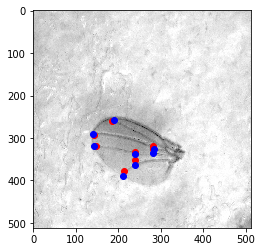

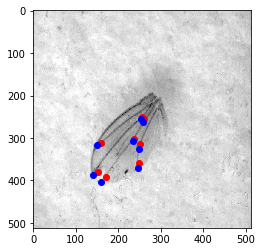

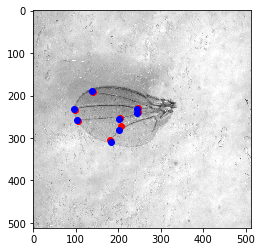

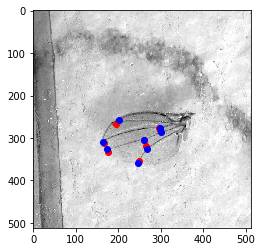

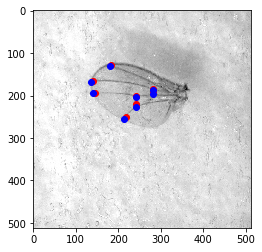

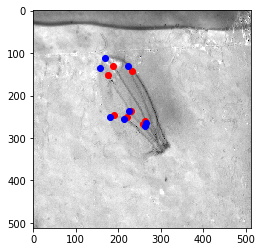

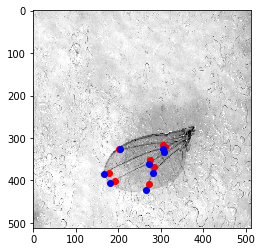

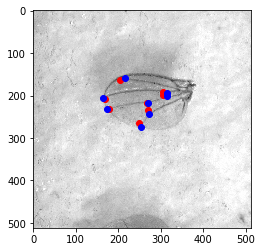

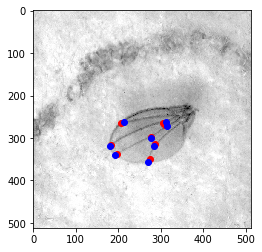

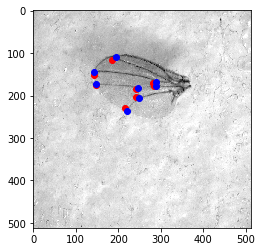

In [23]:
strt_idx = 20
# for i in range(strt_idx, strt_idx+5, 1):
for i in range(0, BATCH_SIZE, 1):
    print(validation_paths[i])
    img_in = input_tensor[i][0].cpu().detach().numpy()
#     gt_pts = output_valid[i][0]
    print("Shape est={}, gt={}".format(output_valid.shape, input_valid.shape))

#     f, axarr = plt.subplots(1,2)
    plt.figure()
    plt.imshow(img_in, cmap='gray')
    plt.scatter(output_valid[i][::2], output_valid[i][1::2], c='r')
    plt.scatter(input_valid[i][::2], input_valid[i][1::2], c='b')
#     plt.scatter(input_valid[i][8], input_valid[i][9], c='b')
#     print(input_valid[i])
#     axarr[0].imshow(img_in, cmap='gray')